Load up experiment & annotations

In [17]:
import sys
sys.path.append('/tmp/pycharm_project_688/')
sys.path.append('/tmp/pycharm_project_688/src/')

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction
from preprocessing._segmentation import segment_null_classification

%load_ext autoreload
%autoreload 2

from classification.classification import classify_all
from data_reading.phyphox import read_experiment, read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import align_data, segment_windows, merge_left_and_right_chunk
from visualization import plot_duration_histogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
complete_experiments_indices = [1,2,3,5,7]
experiment_dirs = [experiment_dirs[i] for i in complete_experiments_indices]
sample_rate = 50
chunks = {"right": [], "left": []}
null_chunks = {"right": [], "left": []}
y_columns = ["start", "end", "label", "hand"]
y = pd.DataFrame(columns=y_columns)
#del experiment_dirs[1]
for directory in experiment_dirs:
    offsets = {}
    with open(directory + "/offset.txt") as f:
        for line in f:
           (key, val) = line.split(": ")
           offsets[key.lower()] = val

    data_frames = read_experiment(directory, offsets=offsets)
    data_frames = {key : align_data(data_frame, listening_rate=1000/sample_rate, reference_sensor=None) for key, data_frame in data_frames.items()}

    y_user = pd.read_csv(directory + "/annotations.tsv", delimiter="\t", header=None)
    hands = pd.read_csv(directory + "/hands.tsv", delimiter="\t", header=None)
    y_user = y_user.iloc[:, [3,5,8]]
    hands = hands.iloc[:, [8]]
    y_user = pd.concat([y_user, hands], axis=1)
    y_user.columns = y_columns
    y = pd.concat([y, y_user], axis=0)

    # iterate over the annotations and split the timeseries in chunks
    for key, df in data_frames.items():
        if key in chunks:
            chunks[key] += [df.iloc[int(annotation["start"]*sample_rate):int(annotation["end"]*sample_rate)] for i, annotation in y_user.iterrows()]
            # null chunks are everything in between annotations
            null_chunks[key] += [df.iloc[int(annotation["end"]*sample_rate):int(y_user.iloc[i+1:i+2]["start"]*sample_rate)] for i, annotation in y_user.iterrows() if i < len(y_user)-1]

/tmp/pycharm_project_688/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


In [20]:
# append the activity label (as int) and the action id to the dataframe
# we need to do this to be able to extract time series features later

labels = y.loc[:, "label"].unique()
label_ids = { l: i for l,i in zip(labels, range(0,len(labels))) }

# list of tuples (left chunk, right chunk)
chunks_two_handed = []
# list of chunks
chunks_one_handed = []

y = y.replace(label_ids)


for i, cl in zip(range(len(y)), y.iterrows()):
    label_id = int(cl[1]["label"])
    action_id = i
    two_handed_chunk = []
    for hand, chunk_list in chunks.items():
        c = chunk_list[i]
        chunk_hand = cl[1]["hand"]
        two_handed_chunk.append(c)
        one_handed_chunk = c
        one_handed_chunk["action_id"] = action_id
        if chunk_hand == hand:
            #c["activity"] = label_id
            chunks_one_handed.append(one_handed_chunk)
    two_handed_chunk = merge_left_and_right_chunk(two_handed_chunk[0], two_handed_chunk[1], action_id)
    chunks_two_handed.append(two_handed_chunk)

labels = y.loc[:, "label"].squeeze()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
window_size = 100

In [22]:
# prepare null chunks
null_class_chunks = []

# TODO: assert that this list is disjoint to the list of action ids from activities
null_action_ids = range(len(chunks_two_handed),len(chunks_two_handed)+len(null_chunks["right"]))
for c_r, c_l, action_id in zip(null_chunks["right"], null_chunks["left"], null_action_ids):
    if len(c_l):
        c_both = merge_left_and_right_chunk(c_l, c_r, action_id)
        null_class_chunks.append(c_both)

In [23]:
#null_class_chunks

### Feature extraction for 2 handed classifier of activities against each other

In [24]:
chunks_two_handed_segmented, labels = segment_windows(chunks_two_handed, labels.to_numpy(), window_size)

/tmp/pycharm_project_688/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


In [25]:
features_two_handed = extract_timeseries_features(pd.concat(chunks_two_handed_segmented).reset_index(drop=True))

Feature Extraction: 100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


In [26]:
features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

variable,acceleration x__abs_energy,acceleration x__absolute_sum_of_changes,"acceleration x__agg_autocorrelation__f_agg_""mean""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""median""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""var""__maxlag_40","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,gyroscope z_right__symmetry_looking__r_0.9500000000000001,gyroscope z_right__time_reversal_asymmetry_statistic__lag_1,gyroscope z_right__time_reversal_asymmetry_statistic__lag_2,gyroscope z_right__time_reversal_asymmetry_statistic__lag_3,gyroscope z_right__value_count__value_-1,gyroscope z_right__value_count__value_0,gyroscope z_right__value_count__value_1,gyroscope z_right__variance,gyroscope z_right__variance_larger_than_standard_deviation,gyroscope z_right__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",335.691573,21.097479,0.133621,-0.017690,0.106529,2.482934,2.356868,2.360906,-0.257856,2.784532,...,1.0,4.513170e-02,0.152618,0.266694,0.0,0.0,0.0,1.080507,1.0,12.385001
"(1, 0)",3877.308789,21.311761,0.049213,0.068506,0.084930,7.109542,6.798426,6.540293,0.051273,7.367973,...,1.0,-1.014314e-03,-0.000924,-0.000420,0.0,0.0,0.0,0.016179,0.0,-3.273792
"(2, 0)",2531.941688,38.016603,0.293920,0.139943,0.093542,8.106730,7.811056,7.834927,-0.324489,6.738275,...,1.0,3.002945e-01,0.731485,1.238221,0.0,0.0,0.0,2.701336,1.0,1.760375
"(3, 0)",1305.831506,30.335685,0.060533,-0.054924,0.152271,2.788632,1.979344,1.476563,0.157501,4.902031,...,1.0,6.106285e-04,0.001308,0.002724,0.0,0.0,0.0,0.064406,0.0,-3.230776
"(4, 0)",1377.436769,39.271765,0.143991,0.036362,0.206623,0.755308,-1.253178,-3.297207,1.763479,7.237778,...,1.0,3.781596e-07,0.000005,0.000012,0.0,0.0,0.0,0.012824,0.0,-4.252662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(402, 1)",10188.884400,55.811687,-0.018294,0.021426,0.150623,12.581981,9.761183,7.773604,2.325430,14.067825,...,1.0,6.115195e-03,0.006354,0.006853,0.0,0.0,0.0,0.197116,0.0,0.772886
"(403, 0)",9518.683807,75.712838,-0.022107,-0.037690,0.118833,13.203516,9.327701,6.130425,7.603202,14.524950,...,1.0,-2.527251e-02,0.018386,0.149439,0.0,0.0,0.0,1.356022,1.0,7.268475
"(403, 1)",8661.267707,15.410089,-0.027041,-0.074981,0.093465,10.301466,9.458734,8.789383,0.306330,10.398345,...,1.0,9.198265e-02,0.211485,0.369083,0.0,0.0,0.0,1.304598,1.0,-6.235624


### Feature selection for 2 handed classifier of activities against each other

In [27]:
# Off-the-shelve feature selection from tsfresh

impute(features_two_handed)
X_two_handed_selected = select_features(features_two_handed, pd.Series(labels))
X_two_handed_selected

variable,acceleration x_right__abs_energy,acceleration y_right__quantile__q_0.3,acceleration y_right__quantile__q_0.4,"acceleration x_right__fft_coefficient__attr_""abs""__coeff_0",acceleration x_right__c3__lag_2,acceleration x_right__c3__lag_3,acceleration x_right__c3__lag_1,acceleration y_right__quantile__q_0.2,acceleration y_right__median,"acceleration x_right__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""",...,gyroscope z__percentage_of_reoccurring_values_to_all_values,gyroscope z__percentage_of_reoccurring_datapoints_to_all_datapoints,gyroscope z__large_standard_deviation__r_0.35000000000000003,gyroscope z__has_duplicate,acceleration z__large_standard_deviation__r_0.2,acceleration y__large_standard_deviation__r_0.15000000000000002,acceleration y__large_standard_deviation__r_0.25,acceleration z__ar_coefficient__coeff_2__k_10,gyroscope x_right__large_standard_deviation__r_0.15000000000000002,gyroscope x__large_standard_deviation__r_0.35000000000000003
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",2603.204288,7.753095,8.368497,469.275302,-154.915042,-151.647788,-158.544846,6.405243,8.726356,-3.504808,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-2.793905,1.0,0.0
"(1, 0)",8500.492435,-4.562419,-4.361483,921.004920,-777.831335,-775.785312,-781.613126,-4.689653,-4.211611,-9.292920,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.688547,1.0,0.0
"(2, 0)",7520.204895,-4.320763,-4.281942,856.344894,-673.739590,-672.016729,-674.416351,-4.362867,-4.242828,-9.015208,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.903133,1.0,0.0
"(3, 0)",1177.458749,9.016227,9.112631,331.642423,-40.571688,-37.882709,-43.299503,8.940934,9.179389,-3.368071,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.819473,1.0,0.0
"(4, 0)",1051.498788,9.083448,9.106947,323.427361,-34.131932,-33.869359,-34.325205,9.068100,9.129947,-3.102381,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.527391,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(402, 1)",7356.541436,0.741487,1.003806,853.075016,-631.026413,-627.449760,-639.275994,0.418698,1.270734,-8.411399,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.938908,1.0,0.0
"(403, 0)",5768.387662,5.585120,6.029838,743.887185,-412.504441,-404.547507,-434.863258,4.981410,6.611740,-7.198549,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.547341,1.0,0.0
"(403, 1)",5661.051096,4.897308,5.240798,739.876641,-405.949790,-402.874240,-425.986215,4.416520,5.654672,-7.642986,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.734695,1.0,0.0


In [28]:
pd.Series(labels)
label_ids

{'pulling door': 0,
 'pushing door': 1,
 'walking': 2,
 'checking oven': 3,
 'washing hands': 4,
 'drying hands': 5,
 'pulling hair': 6,
 'cleaning leg': 7,
 'standing up': 8,
 'cleaning window': 9,
 'cleaning cup': 10,
 'sitting down': 11,
 'cleaning floor': 12,
 'cleaning table': 13,
 'walking ': 14,
 'pulling  door': 15,
 'checking  oven': 16,
 'cleaning  cup': 17,
 'cleaning  floor': 18,
 'pulling hair ': 19}

In [29]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

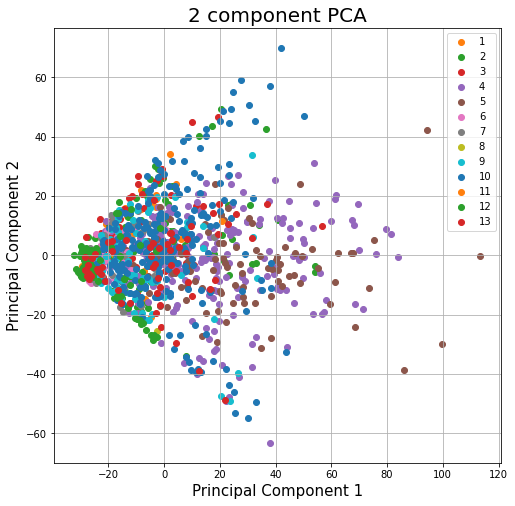

In [30]:
from visualization._visualization import pca_2d, sne_2d

#sne_2d(X=X, y=labels, targets=[1,2,3,4,5,6,7,8,9,10,11,12,13], colors=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13'], n_iter=200000, perplexity=25)
pca_2d(X=X, y=labels, targets=[1,2,3,4,5,6,7,8,9,10,11,12,13], colors=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13'])

In [31]:
#from sklearn.feature_selection import VarianceThreshold
#sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
#X_two_handed_selected = sel.fit_transform(X)

In [32]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif

#X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
#X_two_handed_selected

Train models and score results

In [ ]:
print("Two handed classification")
classify_all(X, labels, label_ids)

Two handed classification


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
